In [1]:
!pip install gymnasium matplotlib


In [2]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from typing import Tuple, List, Dict
from pathlib import Path


# Clase principal

In [41]:
class QueryRouterEnv(gym.Env):
    metadata = {"render_modes": []}

    ctx_bins  = ["small", "medium", "large"]
    tool_bins = [0, 1, 2, 3]               # 3 ≡ "≥3"
    resp_bins = ["short", "medium", "long"]
    n_states  = 36
    action_map = ["gpt-3.5-16k", "gpt-4o-128k", "gemini-32k"]

    def __init__(self):
        self.action_space      = gym.spaces.Discrete(3)
        self.observation_space = gym.spaces.Discrete(self.n_states)
        self.max_steps = 100
        self.rng = np.random.default_rng()
        self.state = None
        self.step_cnt = 0

        # -------- base μ_q, σ_q, μ_lat para ctx = small
        self.base_perf = np.array([      # tools × resp × model
            [[(0.78,0.07,0.25),(0.91,0.04,0.55),(0.83,0.07,0.35)],
             [(0.72,0.07,0.40),(0.90,0.04,0.75),(0.82,0.07,0.55)],
             [(0.65,0.08,0.55),(0.91,0.04,0.95),(0.84,0.07,0.70)]],
            [[(0.75,0.08,0.30),(0.90,0.04,0.60),(0.82,0.07,0.40)],
             [(0.70,0.08,0.45),(0.90,0.04,0.85),(0.80,0.07,0.60)],
             [(0.63,0.09,0.60),(0.92,0.04,1.05),(0.85,0.06,0.80)]],
            [[(0.73,0.08,0.35),(0.89,0.04,0.65),(0.81,0.07,0.45)],
             [(0.68,0.08,0.50),(0.91,0.04,0.90),(0.82,0.07,0.65)],
             [(0.60,0.09,0.65),(0.92,0.04,1.10),(0.85,0.06,0.85)]],
            [[(0.70,0.08,0.40),(0.88,0.04,0.70),(0.80,0.07,0.50)],
             [(0.65,0.08,0.55),(0.91,0.04,1.00),(0.82,0.07,0.70)],
             [(0.58,0.10,0.70),(0.92,0.04,1.20),(0.85,0.06,0.90)]],
        ], dtype=object)

    # ---------- helpers ----------
    def encode(self, ctx_idx, tool_idx, resp_idx):
        return ctx_idx*12 + tool_idx*3 + resp_idx

    def decode(self, s):
        return s//12, (s%12)//3, s%3

    # --- helpers --------------------------------------------
    def _adjust_for_ctx(self, ctx, tools, resp):
        arr = np.array(self.base_perf[tools][resp], dtype=float)

        if ctx == 1:          # medium
            arr[0,0] -= 0.10; arr[0,2] += 0.20
            arr[1,0] += 0.15; arr[1,2] += 0.20
            arr[2,0] += 0.04; arr[2,2] += 0.20
        elif ctx == 2:        # large
            arr[0,0] -= 0.30; arr[0,2] += 0.40
            arr[1,0] += 0.25; arr[1,2] += 0.40
            arr[2,0] -= 0.05; arr[2,2] += 0.25

        # bonificación extra para GPT-4o en problemas “pesados”
        if tools == 3 or resp == 2:
            arr[1,0] += 0.15          # +0.15 de calidad

        return arr


    # --- sampling -------------------------------------------
    def _sample_state(self):
        while True:
            ctx   = self.rng.choice(3, p=[0.55, 0.35, 0.10])
            tools = self.rng.choice(4, p=[0.45, 0.30, 0.15, 0.10])
            resp  = self.rng.choice(3, p=[0.45, 0.40, 0.15])

            # descarta contexto large con 0 tools (imposible)
            if not (ctx == 2 and tools == 0):
                return self.encode(ctx, tools, resp)

    # ---------- gym interface ----------
    def reset(self, seed=None, options=None):
        super().reset(seed=seed); self.step_cnt = 0
        self.state = self._sample_state()
        return self.state, {}

    def step(self, action):
        ctx, tools, resp = self.decode(self.state)

        # acción inviable: modelo sin ventana suficiente
        if ctx == 2 and action in (0, 2):
            reward = -10.0
        else:
            mu_q, sig_q, mu_lat = self._adjust_for_ctx(ctx, tools, resp)[action]
            q      = np.clip(self.rng.normal(mu_q, sig_q), 0.0, 1.0)
            lat_s  = max(0.1, self.rng.normal(mu_lat, 0.05))
            reward = q - 1.0 * lat_s            # λ = 1.0  → reward≈0 – 1

        self.step_cnt += 1
        done = self.step_cnt >= self.max_steps
        self.state = None if done else self._sample_state()
        return self.state, reward, done, False, {}


In [42]:
def train_q(env, episodes=50_000, alpha=0.1, gamma=0.95, eps_start=1.0, eps_end=0.05):
    n_states = env.observation_space.n
    n_actions = env.action_space.n
    Q = np.zeros((n_states, n_actions))
    rewards = []
    for ep in range(episodes):
        s, _ = env.reset()
        done = False
        total = 0.0
        eps = max(eps_end, eps_start - (eps_start - eps_end) * ep / episodes)
        while not done:
            a = env.action_space.sample() if np.random.rand() < eps else np.argmax(Q[s])
            s2, r, done, _, _ = env.step(a)
            best_next = 0 if done else np.max(Q[s2])
            Q[s, a] += alpha * (r + gamma * best_next - Q[s, a])
            s = s2
            total += r
        rewards.append(total)
    return Q, rewards

In [43]:
def plot_rewards(rewards, window=500):
    ma = np.convolve(rewards, np.ones(window)/window, mode="valid")
    plt.plot(ma)
    plt.xlabel(f"Episodios (window={window})")
    plt.ylabel("Reward medio")
    plt.title("Convergencia Q-Learning")

# Entrenar modelo

In [44]:
env = QueryRouterEnv()
Q, rewards = train_q(env, episodes=60_000)

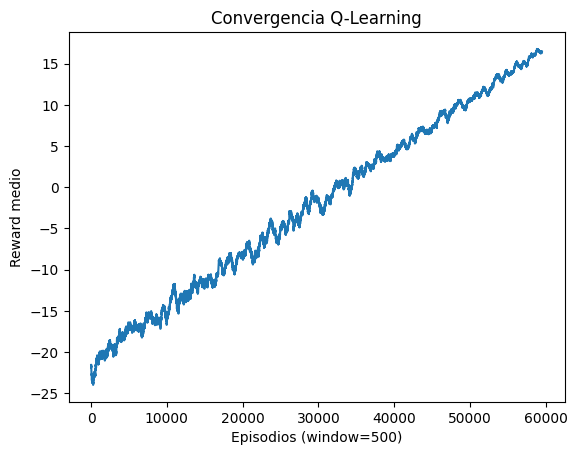

In [45]:
plot_rewards(rewards)
plt.show()

# Guardar/ Cargar la Q-table

In [46]:
np.save("Q_router.npy", Q)        # guarda
Q = np.load("Q_router.npy")       # carga


In [47]:
Q

array([[ 3.37017556,  3.42280707,  3.68660262],
       [ 3.41562473,  3.19756832,  3.16800293],
       [ 2.94827547,  3.1607503 ,  2.9842103 ],
       [ 3.41956686,  3.32375063,  3.60228531],
       [ 3.42140568,  3.06079126,  3.08435147],
       [ 2.83594986,  3.00739962,  3.07411891],
       [ 3.14248609,  3.12047038,  3.52605394],
       [ 3.28756231,  2.990306  ,  3.05992445],
       [ 3.13714323,  2.62922056,  2.65144113],
       [ 3.0440374 ,  3.3143795 ,  3.17111342],
       [ 2.93595529,  3.1824672 ,  2.8472549 ],
       [ 2.70953511,  2.52492497,  3.06525488],
       [ 3.18795998,  3.18293133,  3.49000107],
       [ 2.74459901,  2.85042861,  3.13908955],
       [ 2.40460981,  2.6857964 ,  3.10345802],
       [ 3.01627042,  3.00445549,  3.15504238],
       [ 2.78169138,  2.74026946,  3.21901267],
       [ 2.57453029,  2.95467203,  2.57133423],
       [ 2.92222643,  3.16692552,  2.89700113],
       [ 2.65152015,  2.57367562,  3.13003015],
       [ 2.63532813,  2.59426354,  2.955

# Mostrar la politica aprendida

In [48]:
model_names = ["gpt-3.5-16k", "gpt-4o-128k", "gemini-32k"]

def show_policy(Q, env):
    for s in range(env.observation_space.n):
        a = np.argmax(Q[s])
        ctx, tools, resp = env.decode(s)
        ctx_label   = env.ctx_bins[ctx]          # small / medium / large
        tools_label = f"{env.tool_bins[tools]}" if tools < 3 else "≥3"
        resp_label  = env.resp_bins[resp]        # short / medium / long
        print(f"{ctx_label:<6} | tools {tools_label:<2} | resp {resp_label:<6} -> {model_names[a]}")


In [49]:
show_policy(Q,env)

small  | tools 0  | resp short  -> gemini-32k
small  | tools 0  | resp medium -> gpt-3.5-16k
small  | tools 0  | resp long   -> gpt-4o-128k
small  | tools 1  | resp short  -> gemini-32k
small  | tools 1  | resp medium -> gpt-3.5-16k
small  | tools 1  | resp long   -> gemini-32k
small  | tools 2  | resp short  -> gemini-32k
small  | tools 2  | resp medium -> gpt-3.5-16k
small  | tools 2  | resp long   -> gpt-3.5-16k
small  | tools ≥3 | resp short  -> gpt-4o-128k
small  | tools ≥3 | resp medium -> gpt-4o-128k
small  | tools ≥3 | resp long   -> gemini-32k
medium | tools 0  | resp short  -> gemini-32k
medium | tools 0  | resp medium -> gemini-32k
medium | tools 0  | resp long   -> gemini-32k
medium | tools 1  | resp short  -> gemini-32k
medium | tools 1  | resp medium -> gemini-32k
medium | tools 1  | resp long   -> gpt-4o-128k
medium | tools 2  | resp short  -> gpt-4o-128k
medium | tools 2  | resp medium -> gemini-32k
medium | tools 2  | resp long   -> gemini-32k
medium | tools ≥3 | resp 

# Evaluar politica vs baseline

In [50]:
def evaluate(env, policy_q, episodes=10_000):
    total = 0.0
    for _ in range(episodes):
        s, _ = env.reset()
        done = False
        while not done:
            a = np.argmax(policy_q[s])
            s, r, done, _, _ = env.step(a)
            total += r
    return total / episodes

def evaluate_fixed(env, action, episodes=10_000):
    total = 0.0
    for _ in range(episodes):
        s, _ = env.reset()
        done = False
        while not done:
            s, r, done, _, _ = env.step(action)
            total += r
    return total / episodes

In [51]:
env_eval = QueryRouterEnv()
avg_rl   = evaluate(env_eval, Q)
avg_fix  = evaluate_fixed(env_eval, action=0)   # siempre GPT-3.5
print("Reward medio RL:", avg_rl)
print("Reward medio baseline:", avg_fix)


Reward medio RL: 19.62318132239386
Reward medio baseline: -38.78763331307374


# Comparar Q-Learning vs SARSA

In [55]:
def train_sarsa(env, episodes=50_000, alpha=0.1, gamma=0.95,
                eps_start=1.0, eps_end=0.05):
    n_s = env.observation_space.n
    n_a = env.action_space.n
    Q = np.zeros((n_s, n_a))
    rewards = []

    for ep in range(episodes):
        s, _ = env.reset()
        eps = max(eps_end, eps_start - (eps_start - eps_end) * ep / episodes)
        # primera acción ε-greedy
        if np.random.rand() < eps:
            a = env.action_space.sample()
        else:
            a = np.argmax(Q[s])

        total = 0.0
        while True:
            s2, r, done, _, _ = env.step(a)
            total += r

            if done:
                # actualización terminal: no hay Q[s2,a2]
                Q[s, a] += alpha * (r - Q[s, a])
                break

            # acción siguiente ε-greedy
            if np.random.rand() < eps:
                a2 = env.action_space.sample()
            else:
                a2 = np.argmax(Q[s2])

            # actualización SARSA
            Q[s, a] += alpha * (r + gamma * Q[s2, a2] - Q[s, a])

            s, a = s2, a2

        rewards.append(total)

    return Q, rewards


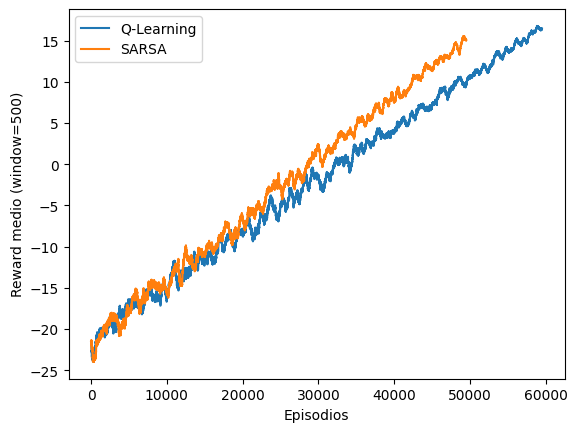

In [56]:
Q_sarsa, r_sarsa = train_sarsa(env)
ma_q   = np.convolve(rewards, np.ones(500)/500, mode="valid")
ma_s   = np.convolve(r_sarsa, np.ones(500)/500, mode="valid")

plt.plot(ma_q, label="Q-Learning")
plt.plot(ma_s, label="SARSA")
plt.xlabel("Episodios")
plt.ylabel("Reward medio (window=500)")
plt.legend()
plt.show()


In [57]:
Q_sarsa

array([[ 2.15780159,  2.1832911 ,  2.90138344],
       [ 1.79497581,  1.53372926,  2.78329139],
       [ 2.02075054,  2.51472333,  1.43971795],
       [ 2.83734216,  2.49060693,  2.71489286],
       [ 2.68618467,  2.21402493,  1.94114344],
       [ 2.19918828,  2.09115447,  2.47271841],
       [ 2.73683181,  2.29849681,  2.29403201],
       [ 1.87316718,  2.35212302,  1.58471878],
       [ 2.38240134,  2.04931738,  1.91601615],
       [ 2.42448293,  2.69552795,  2.33377963],
       [ 2.60419728,  1.82027109,  2.22843989],
       [ 1.84139848,  1.28880008,  2.31330044],
       [ 2.00431242,  2.54598683,  2.75915352],
       [ 2.15478237,  2.2642805 ,  2.18197952],
       [ 2.03020642,  1.61030434,  2.38128071],
       [ 1.70421495,  2.12506244,  2.62531714],
       [ 2.08309166,  2.4073288 ,  2.2507748 ],
       [ 2.05603783,  1.92084247,  1.78645246],
       [ 2.42072923,  1.90828131,  2.29433197],
       [ 2.06389268,  2.29763821,  2.052106  ],
       [ 1.90704965,  1.70060468,  2.318

In [58]:
avg_sarsa = evaluate(env_eval, Q_sarsa)

print("Reward medio SARSA:", avg_sarsa)

Reward medio SARSA: 18.08868265934559
